In [256]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt


#data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#NLP tools
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nandinitengli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [257]:
ids = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')[["file_id", "label"]]
ids.head()

,file_id,label
0,12834217_1,noHate
1,12834217_2,noHate
2,12834217_3,noHate
3,12834217_4,hate
4,12834217_5,noHate


In [258]:
def get_data(paths, group):
  
    sets = []
    for p in paths:

        with open(p) as f:
            file_id = p.split('/')[-1].split('.')[0]
            sets.append((file_id, f.read(), group))

    return pd.DataFrame(sets, columns=["file_id", "text", "gSet"])

In [259]:
#Read Data from CSV files and combine into one set 
import glob

train_file = get_data(glob.glob('./hate-speech-dataset/sampled_train/*.txt'), 'train')
test_file = get_data(glob.glob('./hate-speech-dataset/sampled_test/*.txt'), 'test')

train_file = train_file.join(ids.set_index('file_id'), on='file_id').drop(['file_id', 'gSet'], axis=1)
test_file = test_file.join(ids.set_index('file_id'), on='file_id').drop(['file_id', 'gSet'], axis=1)

comb_set = pd.concat([train_set, test_set]).reset_index(drop=True).drop(['file_id', 'gSet'], axis=1)

In [260]:
comb_set.head()

,text,label
0,Ready .... GO !!!,noHate
1,If i sent you some pic wound use be able to pu...,noHate
2,ALWAYS SPEAK OUT WHEN IN A CLASS WITH A BRAINW...,noHate
3,They fit the same DNA as the DNA found in anci...,noHate
4,I would not be surprised if this woman was spe...,hate


In [261]:
#isolate labels to transform using One Hot Encoding
# labels_actual_train = train_file['label'].values
# labels_actual_test = test_file['label'].values

In [262]:
labels = comb_set['label']
tweets = comb_set['text']
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, stratify=labels, test_size=0.25)


In [263]:
#Reset Indexes 
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_test_stats = X_test.copy()

In [264]:
print("Total training samples:", len(X_train))
print("Total test samples:", len(X_test))

X_train.head()

Total training samples: 1794
Total test samples: 598


0    No doubt they 'll be coming up with chocolate-...
1                           Sounds like a smart idea .
2    Every white person from Michigan knows that ou...
3    another coon giving out about Ireland and as i...
4         Gotta represent my coconuts and mangos yo !!
Name: text, dtype: object

In [265]:
X_train.describe()

count          1794
unique         1791
top       I agree .
freq              2
Name: text, dtype: object

In [266]:
X_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1794 entries, 0 to 1793
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
1794 non-null   object
dtypes: object(1)
memory usage: 14.1+ KB


In [267]:
#Random sample tweet
sample_index = 74
print(X_train.iloc[sample_index])

I do not think anyone looks up to white Negroes , just the black ones and then they become wiggers .


<AxesSubplot: >

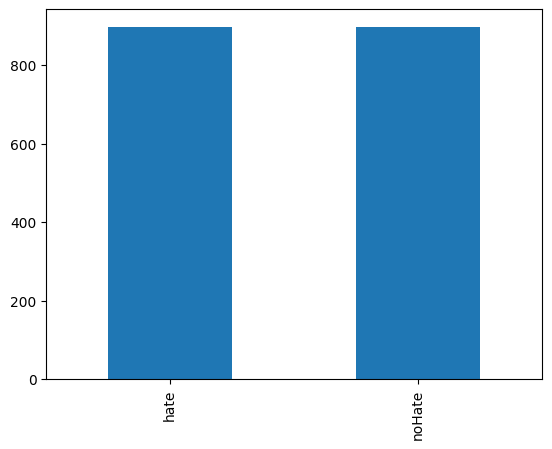

In [268]:
#plot the count of hate tweets vs no hate tweets in the training set
#this is to make sure both are balanced 

y_train.value_counts().plot(kind='bar')

<AxesSubplot: >

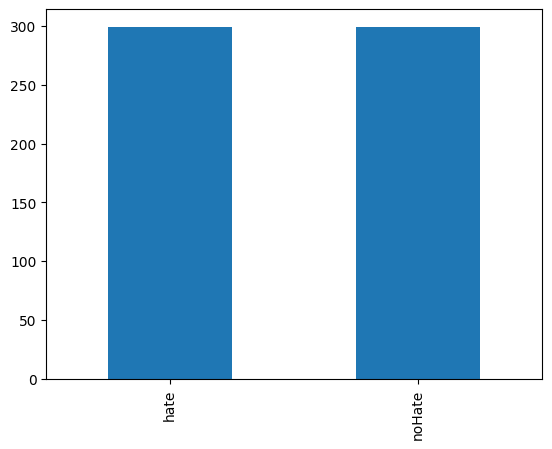

In [269]:
y_test.value_counts().plot(kind='bar')

In [270]:
# Convert the text feature into a vectors of tokens
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(strip_accents='ascii', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b',
                             lowercase=True, stop_words='english')
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)


In [219]:
#dfrequency of words df
word_freq_df = pd.DataFrame(X_train_cv.toarray(), columns=cv.get_feature_names_out())
# top 20 words occuring in training tweets
pd.DataFrame(word_freq_df.sum()).sort_values(0, ascending=False).head(20)

,0
white,299
s,210
t,165
n,160
like,155
just,132
people,126
black,125
whites,105
blacks,74


In [249]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train_cv, y_train)
predictions = clf.predict(X_test_cv)

In [252]:
# Plot scores and make a confusion matrix for non-hate/hate predictions

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

print(f'Number of samples to classify: {len(X_test)}\n')
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')
# print(f'Precision score: {precision_score(y_test, predictions)}')
#print(f'Recall score: {recall_score(y_test, predictions)}\n')
print(f'Confusion matrix: \n{cm}')

Number of samples to classify: 598

Accuracy score: 0.697324414715719
Confusion matrix: 
[[252  47]
 [134 165]]


Text(47.222222222222214, 0.5, 'True label')

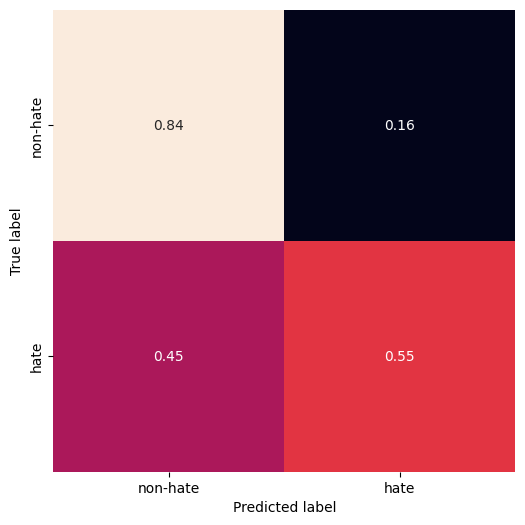

In [254]:
import seaborn as sns
plt.figure(figsize=(6,6))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, square=True, annot=True, cbar=False,
            xticklabels=['non-hate', 'hate'], yticklabels=['non-hate', 'hate'])
plt.xlabel('Predicted label')
plt.ylabel('True label')